# Tensor Completion

Reference tensor is generated from Gaussian Process (GP)

1. Build GP model of the reference tensor
2. Perform tensor completion using random init
3. Perform tensor completion using TT-cross reapproximation of GP model as init

In [1]:
from __future__ import print_function

import numpy as np

%matplotlib inline

from tqdm import tqdm

import pickle
import numpy as np
from matplotlib import interactive, pyplot

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score


import GPy

In [2]:
import tt
from tt.cross import rect_cross

In [14]:
import tensorflow as tf
import t3f
tf.set_random_seed(0)
np.random.seed(0)

In [4]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=DataConversionWarning)


def generate_exact_gp_model(d, random_state=None, ARD=False):
    if random_state is None:
        random_state = np.random.RandomState()

    size = [5] * d
    train_size = min(np.prod(size), 5000)

    sigma = random_state.rand(d) * 0.5 + 0.1
    if ARD:
        kernel = GPy.kern.RBF(d, variance=1, lengthscale=sigma, ARD=True)
    else:
        kernel = GPy.kern.RBF(d, variance=1, lengthscale=sigma[0], ARD=False)
    
    grid_1d = [np.linspace(0, 1, k) for k in size]

    x_grid = np.meshgrid(*grid_1d)
    x_grid = np.hstack((x_grid[i].reshape(-1, 1) for i in range(d)))

    # take subsample if number of points in grid is too large
    x_train = x_grid
    if x_grid.shape[0] > train_size:
        p = np.random.permutation(x_grid.shape[0])
        x_train = x_grid[p[:train_size]]

    y_train = np.random.multivariate_normal(np.zeros(x_train.shape[0]),
                                            kernel.K(x_train, x_train),
                                            size=[1]).reshape(-1, 1)


    model_gp = GPy.models.GPRegression(x_train, y_train, kernel)
    model_gp.kern.lengthscale.fix()
    model_gp.optimize(messages=False)
    return model_gp

def tensor_element(model_gp, x, size=None):
    if size is not None:
        size = np.array(size)
    x = x / (size.reshape(1, -1) - 1)
    
    y = model_gp.predict(x)
    if len(y) == 2:
        return y[0]
    return y


def get_data(model_gp, n, size, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState()
        
    x = np.empty((n, len(size)), dtype=float)
    for i, s in enumerate(size):
        x[:, i] = random_state.randint(s, size=(n, ))

    y = tensor_element(model_gp, x, size)
    x = x / (np.array(size).reshape(1, -1) - 1)
    return x, y


def multiidx2idx(multiidx, size):
    idx = 0
    d = len(size)
    for i, s in enumerate(size[::-1]):
        idx += multiidx[d - i - 1] * s**i
    return idx


def idx2multiidx(idx, size):
    d = len(size)
    idx_copy = np.copy(idx)
    multiidx = np.empty((idx.shape[0], d), dtype=int)

    for i, s in enumerate(size[::-1]):
        multiidx[:, d - i - 1] = idx_copy % s
        idx_copy = (idx_copy - multiidx[:, d - i -1]) // s
        
    return multiidx


def calc_mse(y, x_tt, multiidx):
    error = 0
    for i, index in enumerate(multiidx):
        error += (y[i] - x_tt[index])**2

    error /= len(multiidx)
    return error[0]


def calc_ttcross_errors(model_gp, x):
    test_idx = random_state.randint(10**d, size=(10000))
    multiidx = idx2multiidx(test_idx, size)
    x_test = multiidx / (np.asarray(size) - 1)

    y_test, _ = model_gp.predict(x_test)
    mse = calc_mse(y_test, x, multiidx)
    return mse, np.sqrt(mse) / y_test.std()

### Define loss function

In [5]:
def build_graph(x_init, y_train, train_idx, y_test, test_idx):    
    estimated = t3f.get_variable('estimated', initializer=x_init)

    # Loss
    estimated_vals_train = t3f.gather_nd(estimated, train_idx)
    loss = tf.reduce_mean((estimated_vals_train - y_train) ** 2)
    
    estimated_vals_test = t3f.gather_nd(estimated, test_idx)    
    test_loss = tf.reduce_mean((estimated_vals_test - y_test)**2)
    return loss, test_loss, estimated

#### SGD optimization
The simplest way to solve the optimization problem is Stochastic Gradient Descent: let TensorFlow differentiate the loss w.r.t. the factors (cores) of the TensorTrain decomposition of the estimated tensor and minimize the loss with your favourite SGD variation.

In [6]:
def train(loss, test_loss, estimated_tensor, early_stopping_rounds=50):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    step = optimizer.minimize(loss)

    rounds_without_improvement = 0
    best_test_loss = np.inf
    best_loss_round = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        loss_hist = []
        test_loss_hist = []

        for i in range(1):
            _, loss_v = sess.run([step, loss])
            loss_hist.append(loss_v)
            test_loss_hist.append(sess.run(test_loss))

            if best_test_loss > test_loss_hist[-1]:
                best_test_loss = test_loss_hist[-1]
                best_loss_round = i
                rounds_without_improvement = 0
            else:
                rounds_without_improvement += 1
                
            if rounds_without_improvement >= early_stopping_rounds:
                break
        
        cores = sess.run(estimated_tensor.tt_cores)
        estimated_tensor_ttpy = tt.core.vector.tensor.from_list(cores)
        
#     pyplot.figure()
#     pyplot.plot(loss_hist, label='Train')
#     pyplot.plot(test_loss_hist, label='Test')
#     pyplot.legend()
#     pyplot.show()
        
    return loss_hist, test_loss_hist, estimated_tensor_ttpy

### Random init

In [7]:
def tensor_completion_rand_init(y_train, train_idx, y_test, test_idx, size, rank=2, figure=None):
    tf.reset_default_graph()

    d = train_idx.shape[1]
    x_init = t3f.random_tensor(size, tt_rank=rank)

    loss, test_loss, estimated = build_graph(x_init, y_train, train_idx, y_test, test_idx)
    loss_hist, test_loss_hist, estimated_ttpy = train(loss, test_loss, estimated)

    error_test = calc_mse(y_test, estimated_ttpy, test_idx)
    error_train = calc_mse(y_train, estimated_ttpy, train_idx)
    
    return error_train, error_test, estimated_ttpy

### GP+TT-cross as init

In [8]:
def tensor_completion_gp_init(x_train, y_train, train_idx, y_test, test_idx, size, rank=2):
    d = x_train.shape[1]

    kernel = GPy.kern.RBF(d)
    gp = GPy.models.GPRegression(x_train, y_train, kernel)
    gp.optimize()

    x0 = tt.rand(size, d, rank)
    x_gp = rect_cross.cross(lambda x: gp.predict(x / (np.array(size).reshape(1, -1) - 1))[0],
                            x0, nswp=2, kickrank=1, rf=2)

    tf.reset_default_graph()

    x_gp_cores = tt.core.vector.tensor.to_list(x_gp)
    x_gp_cores = [core.astype(np.float32) for core in x_gp_cores]
    x_init = t3f.TensorTrain(x_gp_cores, size, x_gp.r)

    loss, test_loss, estimated = build_graph(x_init, y_train, train_idx, y_test, test_idx)
    loss_hist, test_loss_hist, estimated_ttpy = train(loss, test_loss, estimated)

    error_test = calc_mse(y_test, estimated_ttpy, test_idx)
    error_train = calc_mse(y_train, estimated_ttpy, train_idx)
    
    return error_train, error_test, gp, x_gp, estimated_ttpy

In [9]:
def tensor_completion_nystrom_init(x_train, y_train, train_idx, y_test, test_idx, size, rank=2, n_inducing=100):
    d = x_train.shape[1]

    kernel = GPy.kern.RBF(d)
    gp = GPy.models.SparseGPRegression(x_train, y_train, num_inducing=n_inducing, kernel=kernel)
    gp.optimize()

    x0 = tt.rand(size, d, rank)
    x_gp = rect_cross.cross(lambda x: gp.predict(x / (np.array(size).reshape(1, -1) - 1))[0],
                            x0, nswp=2, kickrank=1, rf=2)

    tf.reset_default_graph()

    x_gp_cores = tt.core.vector.tensor.to_list(x_gp)
    x_gp_cores = [core.astype(np.float32) for core in x_gp_cores]
    x_init = t3f.TensorTrain(x_gp_cores, size, x_gp.r)

    loss, test_loss, estimated = build_graph(x_init, y_train, train_idx, y_test, test_idx)
    loss_hist, test_loss_hist, estimated_ttpy = train(loss, test_loss, estimated)

    error_test = calc_mse(y_test, estimated_ttpy, test_idx)
    error_train = calc_mse(y_train, estimated_ttpy, train_idx)
    
    return error_train, error_test, gp, x_gp, estimated_ttpy

In [22]:
d_list = range(5, 11)
r_list = [2] * len(d_list)
train_size_default = 1000

n_runs = 1
r = 10

random_state = np.random.RandomState(42)

errors_rand = {'mse_train': [], 'mse_test': [], 'rel_train': [], 'rel_test': []}
errors_gp = {'mse_train': [], 'mse_test': [], 'rel_train': [], 'rel_test': [],
             'model_mse_train': [], 'model_mse_test': [],
             'init_mse_train': [], 'init_mse_test': []}
errors_nys = {'mse_train': [], 'mse_test': [], 'rel_train': [], 'rel_test': [],
              'model_mse_train': [], 'model_mse_test': [],
              'init_mse_train': [], 'init_mse_test': []}


for i, d in enumerate(d_list):

    print('Dim: {}'.format(d))

    # generate problem and training and test sets
    model_gp = generate_exact_gp_model(d, random_state, ARD=False)
    size = [10 for i in range(d)]
    train_size = min(train_size_default, np.prod(size))
    
    test_idx = random_state.randint(10**d, size=(5000))
    test_idx = idx2multiidx(test_idx, size)
    x_test = test_idx / (np.asarray(size) - 1)
    y_test, _ = model_gp.predict(x_test)
    
    for run_counter in range(n_runs):
        print("Run #{}".format(run_counter))

        x_train, y_train = get_data(model_gp, train_size, size, random_state)
        train_idx = (x_train * (np.asarray(size) - 1)).astype(int)

        # Make tensor completion using random init
        results_rand = tensor_completion_rand_init(y_train, train_idx, y_test, test_idx, size,
                                                   rank=r)

        
        # Make tensor completion using KRR+TT-cross as init
        results_gp = tensor_completion_gp_init(x_train, y_train, train_idx, y_test, test_idx, size,
                                               rank=r)

        # Make tensor completion using KRR+TT-cross as init
        results_nys = tensor_completion_nystrom_init(x_train, y_train, train_idx, y_test, test_idx, size,
                                                     rank=r)
        
        gp = results_gp[2]
        x_gp = results_gp[3]
        
        nys = results_nys[2]
        x_nys = results_nys[3]
        for i, mode in enumerate(['train', 'test']):
            for e, res in zip([errors_rand, errors_gp, errors_nys],
                              [results_rand, results_gp, results_nys]):
                e['mse_' + mode].append(res[i])
                e['rel_' + mode].append(np.sqrt(res[i]) / y_test.std())

            if mode == 'train':
                gp_pr = gp.predict(x_train)[0]
                nys_pr = nys.predict(x_train)[0]
                y_truth = y_train
                indices_truth = train_idx
            else:
                gp_pr = gp.predict(x_test)[0]
                nys_pr = nys.predict(x_test)[0]
                y_truth = y_test
                indices_truth = test_idx

            for e, pr, x in zip([errors_gp, errors_nys], [gp_pr, nys_pr], [x_gp, x_nys]):
                e['model_mse_' + mode].append(mean_squared_error(y_truth, pr))
                e['init_mse_' + mode].append(calc_mse(y_truth, x, indices_truth))
        
    
    for mode in ['train', 'test']:
        for e, name in zip([errors_rand, errors_gp, errors_nys],
                           ['rand', 'gp', 'nys']):
            err = e['mse_' + mode][-n_runs:]
            print('{}: {}'.format(name, np.mean(err), np.std(err)))
        
for e in [errors_rand, errors_gp, errors_nys]:
    for key in e:
        e[key] = np.array(e[key]).reshape(len(d_list), n_runs)

Dim: 5
Run #0
swp: 0/1 er_rel = 1.5e+02 er_abs = 3.5e+04 erank = 14.0 fun_eval: 8710
swp: 1/1 er_rel = 3.4e-01 er_abs = 8.0e+01 erank = 17.7 fun_eval: 23470
swp: 0/1 er_rel = 1.6e+02 er_abs = 2.8e+04 erank = 14.0 fun_eval: 8710
swp: 1/1 er_rel = 6.2e-02 er_abs = 1.0e+01 erank = 17.7 fun_eval: 23450
rand: 1.2251231228076656
gp: 0.07765457491748977
nys: 0.22100637246940252
rand: 1.3343138347265302
gp: 0.08396201926588963
nys: 0.2562750523761786
Dim: 6
Run #0
swp: 0/1 er_rel = 3.2e+02 er_abs = 3.0e+05 erank = 14.3 fun_eval: 11730
swp: 1/1 er_rel = 3.9e-01 er_abs = 3.7e+02 erank = 18.6 fun_eval: 33130
swp: 0/1 er_rel = 4.6e+02 er_abs = 3.3e+05 erank = 14.5 fun_eval: 12070
swp: 1/1 er_rel = 1.0e-01 er_abs = 7.3e+01 erank = 18.9 fun_eval: 34050
rand: 1.4434665697000932
gp: 0.23437739658712178
nys: 0.4025384275727982
rand: 1.588030053044588
gp: 0.22790264464283128
nys: 0.4145316205248747
Dim: 7
Run #0
swp: 0/1 er_rel = 1.2e+03 er_abs = 3.3e+06 erank = 14.4 fun_eval: 14970
swp: 1/1 er_rel = 2.

In [ ]:
import pickle
suffix = 'nruns={}'.format(n_runs)
with open('TensorCompletion_toy_problem_errors_rand_{}.pkl'.format(suffix), 'wb') as f:
    pickle.dump(errors_rand, f)

with open('TensorCompletion_toy_problem_errors_gpinit_{}.pkl'.format(suffix), 'wb') as f:
    pickle.dump(errors_gp, f)

In [25]:
err

array([0.25627505, 0.41453162, 0.32796207, 0.66702873, 0.53033176,
       0.99475593])

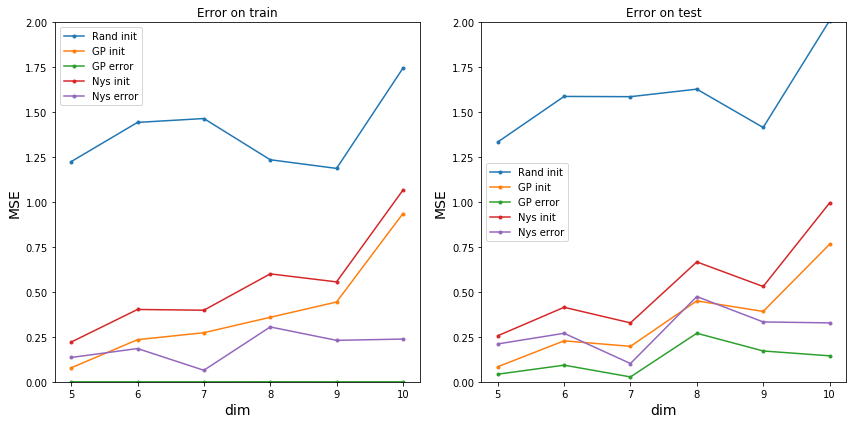

In [28]:
figure = pyplot.figure(figsize=(12, 6))
for i, mode in enumerate(['train', 'test']):
    
    key = 'mse_' + mode
    
    def get_err_std(errors):
        return errors.mean(axis=1), errors.std(axis=1)
    
    ax = figure.add_subplot(1, 2, i + 1)
    for error, name in zip([errors_rand, errors_gp, errors_nys],
                         ['Rand', 'GP', 'Nys']):
    
        err, std = get_err_std(error[key])
        
        ax.plot(d_list, err, '.-', label='{} init'.format(name))
        ax.fill_between(d_list, err - std, err + std, alpha=0.3)
    
        if 'model_mse_train' in error:
            ax.plot(d_list, error['model_mse_' + mode].mean(axis=1), '.-', label='{} error'.format(name))
        ax.legend(loc='best')
        ax.set_ylim([0, 2])
        ax.set_xlabel('dim', fontsize=14)
        ax.set_ylabel('MSE', fontsize=14)
        ax.set_title('Error on {}'.format(mode))
figure.tight_layout()
pyplot.show()

### Larger train size

In [11]:
d_list = range(5, 11)
r_list = [2] * len(d_list)
train_size_default = 5000

n_runs = 1

random_state = np.random.RandomState(42)

errors_rand = {'mse_train': [], 'mse_test': [], 'rel_train': [], 'rel_test': []}
errors_gp = {'mse_train': [], 'mse_test': [], 'rel_train': [], 'rel_test': [],
             'model_mse_train': [], 'model_mse_test': [],
             'init_mse_train': [], 'init_mse_test': []}


for i, d in enumerate(d_list):

    print('Dim: {}'.format(d))

    # generate problem and training and test sets
    model_gp = generate_exact_gp_model(d, random_state, ARD=False)
    size = [10 for i in range(d)]
    train_size = min(train_size_default, np.prod(size))
    
    test_idx = random_state.randint(10**d, size=(5000))
    test_idx = idx2multiidx(test_idx, size)
    x_test = test_idx / (np.asarray(size) - 1)
    y_test, _ = model_gp.predict(x_test)
    
    for run_counter in range(n_runs):
        print("Run #{}".format(run_counter))

        x_train, y_train = get_data(model_gp, train_size, size, random_state)
        train_idx = (x_train * (np.asarray(size) - 1)).astype(int)

        # Make tensor completion using random init
        results_rand = tensor_completion_rand_init(y_train, train_idx, y_test, test_idx, size)

        
        # Make tensor completion using KRR+TT-cross as init
        results_gp = tensor_completion_gp_init(x_train, y_train, train_idx, y_test, test_idx, size)

        gp = results_gp[2]
        x_gp = results_gp[3]
        for i, mode in enumerate(['train', 'test']):
            errors_rand['mse_' + mode].append(results_rand[i])
            errors_rand['rel_' + mode].append(np.sqrt(results_rand[i]) / y_test.std())

            errors_gp['mse_' + mode].append(results_gp[i])
            errors_gp['rel_' + mode].append(np.sqrt(results_gp[i]) / y_test.std())

            if mode == 'train':
                gp_pr = gp.predict(x_train)[0]
                y_truth = y_train
                indices_truth = train_idx
            else:
                gp_pr = gp.predict(x_test)[0]
                y_truth = y_test
                indices_truth = test_idx

            errors_gp['model_mse_' + mode].append(mean_squared_error(y_truth, gp_pr))
            errors_gp['init_mse_' + mode].append(calc_mse(y_truth, x_gp, indices_truth))
            
    for mode in ['train', 'test']:
        err_rand = errors_rand['mse_' + mode][-n_runs:]
        err_gp = errors_gp['mse_' + mode][-n_runs:]
        print('Rand: ', np.mean(err_rand), np.std(err_rand))
        print('GP:   ', np.mean(err_gp), np.std(err_gp))

for key in errors_rand:
    errors_rand[key] = np.array(errors_rand[key]).reshape(len(d_list), n_runs)
    
for key in errors_gp:
    errors_gp[key] = np.array(errors_gp[key]).reshape(len(d_list), n_runs)

Dim: 5
Run #0
swp: 0/1 er_rel = 5.6e+00 er_abs = 1.1e+03 erank = 4.0 fun_eval: 660
swp: 1/1 er_rel = 7.7e-01 er_abs = 1.8e+02 erank = 6.0 fun_eval: 2360
Rand:  1.5422271638591094 0.0
GP:    0.49120650054325243 0.0
Rand:  1.3782530504456378 0.0
GP:    0.4759418834868271 0.0
Dim: 6
Run #0
swp: 0/1 er_rel = 1.9e+01 er_abs = 4.7e+03 erank = 4.0 fun_eval: 840
swp: 1/1 er_rel = 1.0e+00 er_abs = 4.5e+02 erank = 7.1 fun_eval: 3490
Rand:  1.1359798465574393 0.0
GP:    0.5453777644472135 0.0
Rand:  1.140317762480738 0.0
GP:    0.5560440759798366 0.0
Dim: 7
Run #0
swp: 0/1 er_rel = 2.1e+01 er_abs = 3.6e+04 erank = 4.0 fun_eval: 1020
swp: 1/1 er_rel = 8.2e-01 er_abs = 1.7e+03 erank = 6.1 fun_eval: 3730
Rand:  1.6831975242155188 0.0
GP:    0.624310721033959 0.0
Rand:  1.6593485842801543 0.0
GP:    0.6333735788191545 0.0
Dim: 8
Run #0
swp: 0/1 er_rel = 2.1e+01 er_abs = 1.3e+05 erank = 4.0 fun_eval: 1200
swp: 1/1 er_rel = 7.3e-01 er_abs = 5.8e+03 erank = 6.2 fun_eval: 4450
Rand:  1.5221565834763435 0

In [14]:
import pickle
suffix = 'nruns={}_train_size={}'.format(n_runs, train_size)
with open('TensorCompletion_toy_problem_errors_rand_{}.pkl'.format(suffix), 'wb') as f:
    pickle.dump(errors_rand, f)

with open('TensorCompletion_toy_problem_errors_gp_{}.pkl'.format(suffix), 'wb') as f:
    pickle.dump(errors_gp, f)

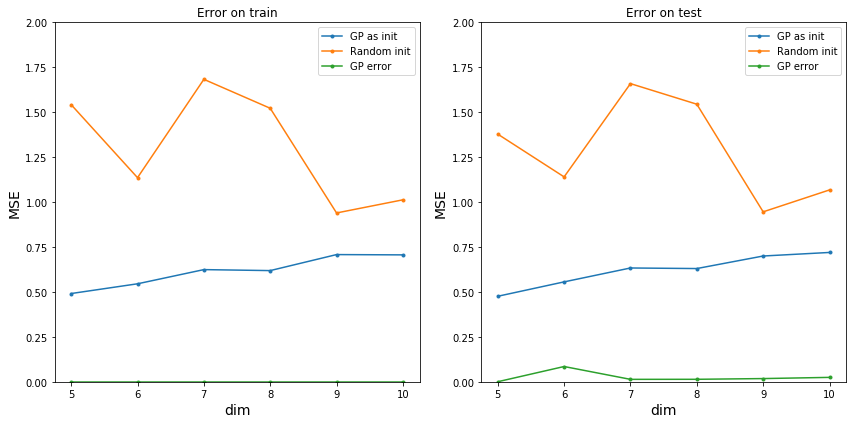

In [12]:
figure = pyplot.figure(figsize=(12, 6))
for i, mode in enumerate(['train', 'test']):
    
    key = 'mse_' + mode
    
    def get_err_std(errors):
        return errors.mean(axis=1), errors.std(axis=1)
    
    
    err_krr, std_krr = get_err_std(errors_gp[key])
    err_rand, std_rand = get_err_std(errors_rand[key])
    
    ax = figure.add_subplot(1, 2, i + 1)
    ax.plot(d_list, err_krr, '.-', label='GP as init')
    ax.fill_between(d_list, err_krr - std_krr, err_krr + std_krr, alpha=0.3)
    
    ax.plot(d_list, err_rand, '.-', label='Random init')
    ax.fill_between(d_list, err_rand - std_rand, err_rand + std_rand, alpha=0.3)
    ax.plot(d_list, errors_gp['model_mse_' + mode].mean(axis=1), '.-', label='GP error')
    ax.legend(loc='best')
    ax.set_ylim([0, 2])
    ax.set_xlabel('dim', fontsize=14)
    ax.set_ylabel('MSE', fontsize=14)
    ax.set_title('Error on {}'.format(mode))
figure.tight_layout()
pyplot.show()

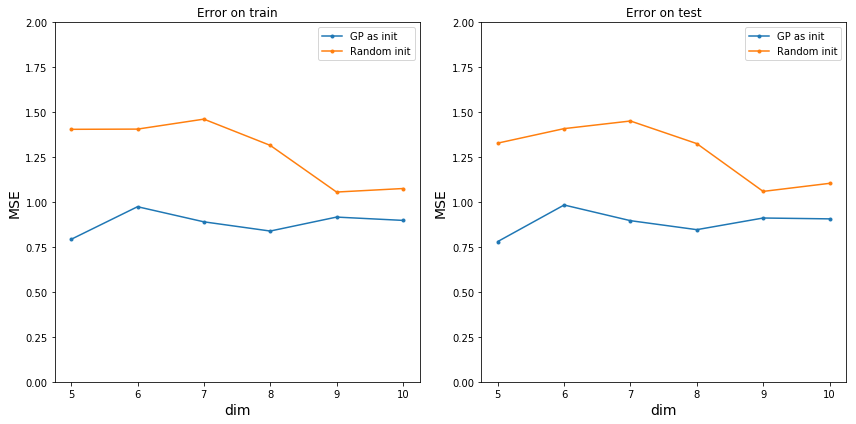

In [13]:
figure = pyplot.figure(figsize=(12, 6))
for i, mode in enumerate(['train', 'test']):
    
    key = 'rel_' + mode
    
    def get_err_std(errors):
        return errors.mean(axis=1), errors.std(axis=1)
    
    
    err_krr, std_krr = get_err_std(errors_gp[key])
    err_rand, std_rand = get_err_std(errors_rand[key])
    
    ax = figure.add_subplot(1, 2, i + 1)
    ax.plot(d_list, err_krr, '.-', label='GP as init')
    ax.fill_between(d_list, err_krr - std_krr, err_krr + std_krr, alpha=0.3)
    
    ax.plot(d_list, err_rand, '.-', label='Random init')
    ax.fill_between(d_list, err_rand - std_rand, err_rand + std_rand, alpha=0.3)
#     ax.plot(d_list, errors_gp['model_rel_' + mode].mean(axis=1), '.-', label='GP error')
    ax.legend(loc='best')
    ax.set_ylim([0, 2])
    ax.set_xlabel('dim', fontsize=14)
    ax.set_ylabel('Relative', fontsize=14)
    ax.set_title('Error on {}'.format(mode))
figure.tight_layout()
pyplot.show()

### Plot 2d slices

In [10]:
d = 5
r = 5
train_size_default = 1000

random_state = np.random.RandomState(42)

print('Dim: {}'.format(d))

# generate problem and training and test sets
model_gp = generate_exact_gp_model(d, random_state, ARD=False)
size = [10 for i in range(d)]
train_size = min(train_size_default, np.prod(size))

test_idx = random_state.randint(10**d, size=(5000))
test_idx = idx2multiidx(test_idx, size)
x_test = test_idx / (np.asarray(size) - 1)
y_test, _ = model_gp.predict(x_test)

Dim: 5


In [11]:
x_train, y_train = get_data(model_gp, train_size, size, random_state)
train_idx = (x_train * (np.asarray(size) - 1)).astype(int)

# Make tensor completion using random init
results_rand = tensor_completion_rand_init(y_train, train_idx, y_test, test_idx, size,
                                           rank=r)

In [12]:
# Make tensor completion using KRR+TT-cross as init
results_gp = tensor_completion_gp_init(x_train, y_train, train_idx, y_test, test_idx, size,
                                       rank=r)

swp: 0/1 er_rel = 2.1e+01 er_abs = 6.1e+03 erank = 8.4 fun_eval: 2780
swp: 1/1 er_rel = 5.3e-01 er_abs = 1.8e+02 erank = 13.8 fun_eval: 10500


In [13]:
x_init = tt.rand(size, d, r)

x_ttcross = rect_cross.cross(lambda x: model_gp.predict(x / (np.array(size) - 1))[0], x_init, nswp=2, kickrank=1, rf=2)

swp: 0/1 er_rel = 2.4e+01 er_abs = 7.3e+03 erank = 9.1 fun_eval: 3190
swp: 1/1 er_rel = 5.6e-01 er_abs = 1.9e+02 erank = 13.8 fun_eval: 11350


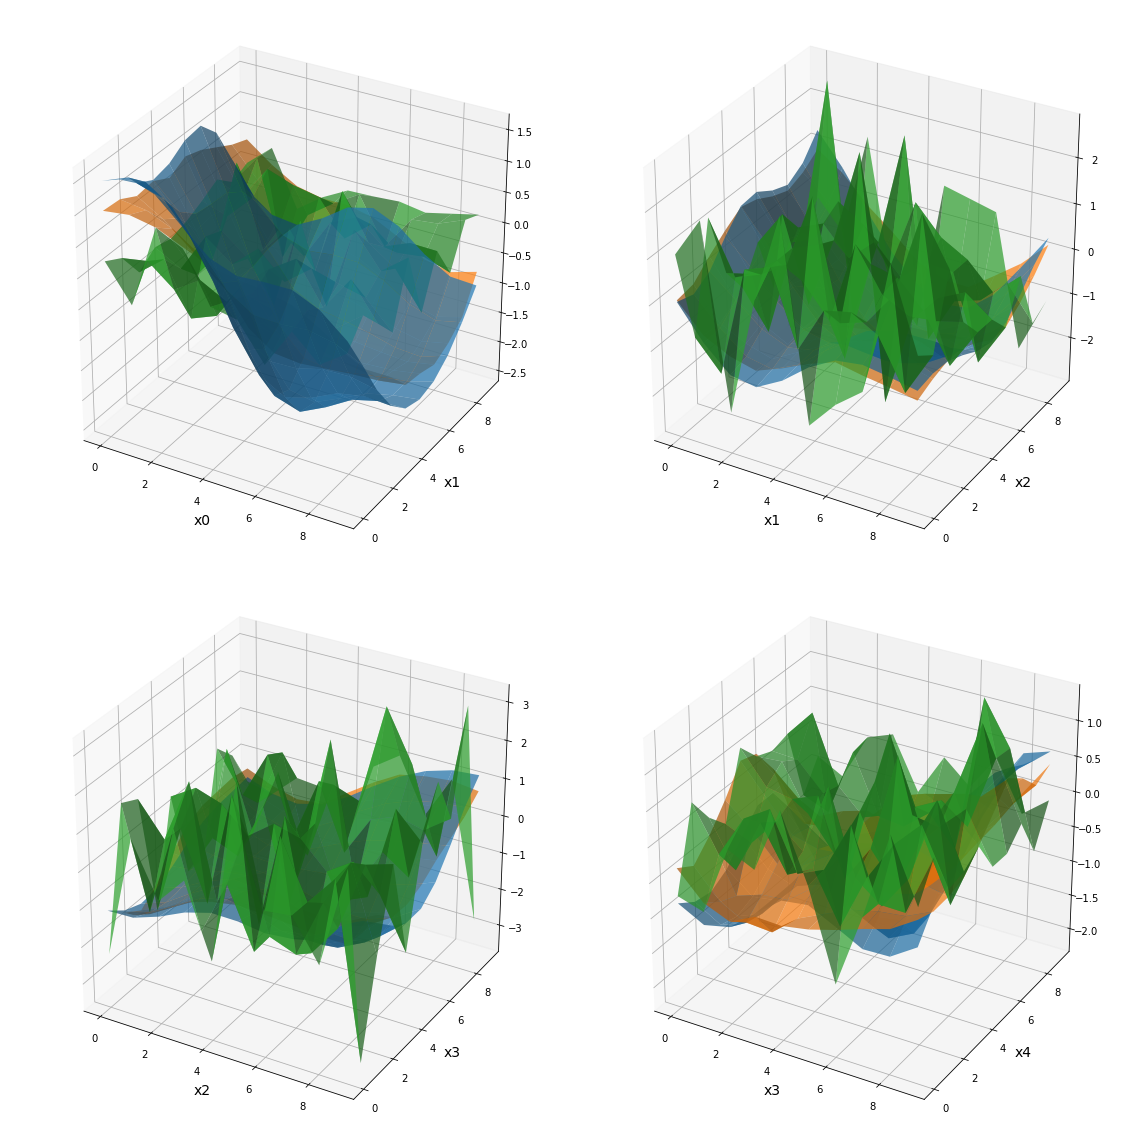

In [19]:
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(42)

d = x_train.shape[1]
n = 10

value = np.random.randint(n, size=(1, d))

figure = pyplot.figure(figsize=(16, 16))
m = int(np.sqrt(d))

for i in range(d):
    for j in range(i + 1, min(i + 2, d)):
        idx = [i, j]

        plot_size = n
        dim = 2

        x0 = np.tile(value, (plot_size**dim, 1))
        XY = np.meshgrid(np.arange(n), np.arange(n))
        x_grid = np.hstack([XY[0].reshape(-1, 1), XY[1].reshape(-1, 1)])
        x0[:, idx] = x_grid
        
        y_exact, _ = model_gp.predict(x0 / (n - 1))
        y_pr, _ = results_gp[2].predict(x0 / (n - 1))
        
        y_tt = np.empty_like(y_pr)
        y_gp = np.empty_like(y_pr)
        y_rand = np.empty_like(y_pr)
        for k, index in enumerate(x0):
            y_gp[k] = results_gp[4][index]
            y_rand[k] = results_rand[2][index]
            y_tt[k] = x_ttcross[index]
        

        ax = figure.add_subplot(m, m, i + 1, projection='3d')
#         ax.plot_surface(XY[0], XY[1], y_pr.reshape(plot_size, plot_size), alpha=0.7)
        ax.plot_surface(XY[0], XY[1], y_exact.reshape(plot_size, plot_size), alpha=0.7)
        # ax.plot_surface(XY[0], XY[1], y_tt.reshape(plot_size, plot_size), alpha=0.7)
        ax.plot_surface(XY[0], XY[1], y_gp.reshape(plot_size, plot_size), alpha=0.7)
        ax.plot_surface(XY[0], XY[1], y_rand.reshape(plot_size, plot_size), alpha=0.7)

        ax.set_xlabel('x{}'.format(i), fontsize=14)
        ax.set_ylabel('x{}'.format(j), fontsize=14)
figure.tight_layout()
pyplot.show()